# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(X.shape)
df = pd.read_csv("data.csv",nrows=5000)

(5000, 400)


In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape
Y[Y == 10] = 0

Afficher aléatoirement quelques données de notre base

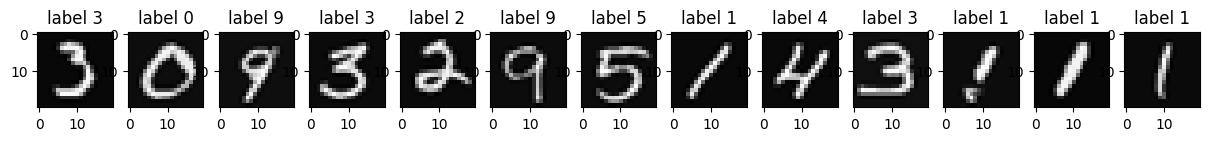

In [5]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

In [6]:
def build_mat_conf(ytt, y_predict):
    mat_conf = np.zeros((10, 10), dtype=np.int32)
    for i in range(len(ytt)):
        mat_conf[ytt[i]][y_predict[i]] += 1
    return mat_conf

def build_mat_conf_binary(ytt, y_predict):
    mat_conf = np.zeros((2, 2), dtype=np.int32)
    for i in range(len(ytt)):
        mat_conf[ytt[i]][y_predict[i]] += 1
    return mat_conf


- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [7]:
def accuracy(conf_mat):
    tp = np.diag(conf_mat)
    tn = np.sum(conf_mat) - (np.sum(conf_mat, axis=0) + np.sum(conf_mat, axis=1) - tp)
    fp = np.sum(conf_mat, axis=0) - tp
    fn = np.sum(conf_mat, axis=1) - tp
    
    return (tp + tn) / (tp + tn + fp + fn)

- Recall (True Positive Rate) = TP/(TP + FN)

In [8]:
def recall(conf_mat):
    tp = np.diag(conf_mat)
    fn = np.sum(conf_mat, axis=1) - tp
    
    return tp / (tp + fn)

- Précision = TP/(TP + FP)

In [9]:
def precision(conf_mat):
    tp = np.diag(conf_mat)
    fp = np.sum(conf_mat, axis=0) - tp
    
    return tp / (tp + fp)


- Taux de FP (False Positive Rate) = FP / (FP + TN)

In [10]:
def false_positive_rate(conf_mat):
    fp = np.sum(conf_mat, axis=0) - np.diag(conf_mat)
    tn = np.sum(conf_mat) - (np.sum(conf_mat, axis=0) + np.sum(conf_mat, axis=1) - np.diag(conf_mat))

    return fp / (fp + tn)

- Spécificité (True Negative Rate) = TN / (TN + FP)

In [11]:
def true_negative_rate(conf_mat):
    fp = np.sum(conf_mat, axis=0) - np.diag(conf_mat)
    tn = np.sum(conf_mat) - (np.sum(conf_mat, axis=0) + np.sum(conf_mat, axis=1) - np.diag(conf_mat))
    
    return tn / (tn + fp)

- Courbe ROC

In [12]:
def roc_digit(y_true, y_prob, thresholds, digit):
    TPR = []
    FPR = []
    y_true_binary = np.zeros(y_true.shape[0])
    y_prob_binary = np.zeros(y_prob.shape[0])
    y_true_binary[y_true == digit] = 1
    for t in thresholds:
        y_prob_binary[np.where(y_prob[:, digit] < t)] = 0
        y_prob_binary[np.where(y_prob[:, digit] >= t)] = 1
        y_prob_binary = y_prob_binary.astype(int)
        y_true_binary = y_true_binary.astype(int)
        conf_mat = build_mat_conf_binary(y_true_binary, y_prob_binary)
        TPR.append(recall(conf_mat)[1])
        FPR.append(false_positive_rate(conf_mat)[1])
    return TPR, FPR

def roc_plot(y_true, y_prob, thresholds):
    plt.figure(figsize=(15, 8))
    for i in range(10):
        TPR, FPR = roc_digit(y_true, y_prob, thresholds, i)
        plt.plot(FPR, TPR, label='digit ' + str(i))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [13]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
      scaled_features, Y, test_size = 0.30, random_state=42)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [14]:
def minkowski_distance(x, y, p):
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

# Méthode 1: MVS
Machine à Vecteurs de Support

In [15]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(X_train, y_train)
# Prediction
y_pred = model.predict(X_test)

mat = build_mat_conf(y_test, y_pred)
mat

array([[163,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0, 148,   1,   0,   0,   1,   0,   0,   0,   2],
       [  0,   2, 136,   4,   3,   2,   1,   0,   7,   0],
       [  0,   2,   5, 134,   1,   5,   1,   1,   3,   2],
       [  0,   0,   3,   0, 129,   0,   0,   1,   1,   9],
       [  1,   3,   0,  11,   3, 123,   0,   0,   0,   0],
       [  3,   0,   0,   0,   0,   1, 139,   0,   0,   0],
       [  1,   3,   2,   0,   3,   0,   1, 142,   1,   5],
       [  1,   2,   4,   2,   0,   5,   1,   0, 116,   1],
       [  2,   0,   0,   1,   7,   1,   1,   6,   0, 140]])

2


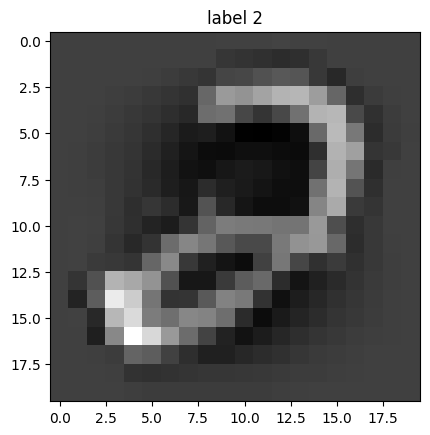

In [16]:
# tester une image
c= 3
print (y_pred[c])
a = X_test[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(y_test[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


In [17]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(X_train, y_train)
# Prediction
y_pred = model.predict(X_test)

2


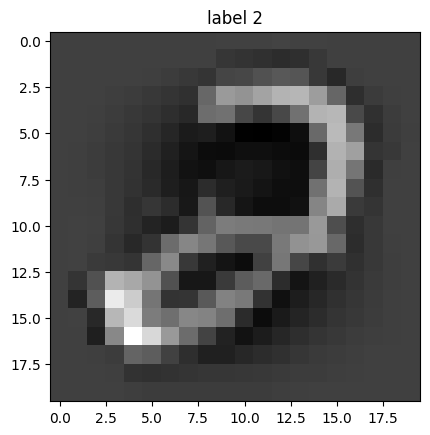

In [18]:
# tester une image
c= 3
print (y_pred[c])
a = X_test[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(y_test[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [19]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [20]:
# Choisir un image de test 
c=0

In [21]:
model.predict([Xtt[c,:]])

array([8])

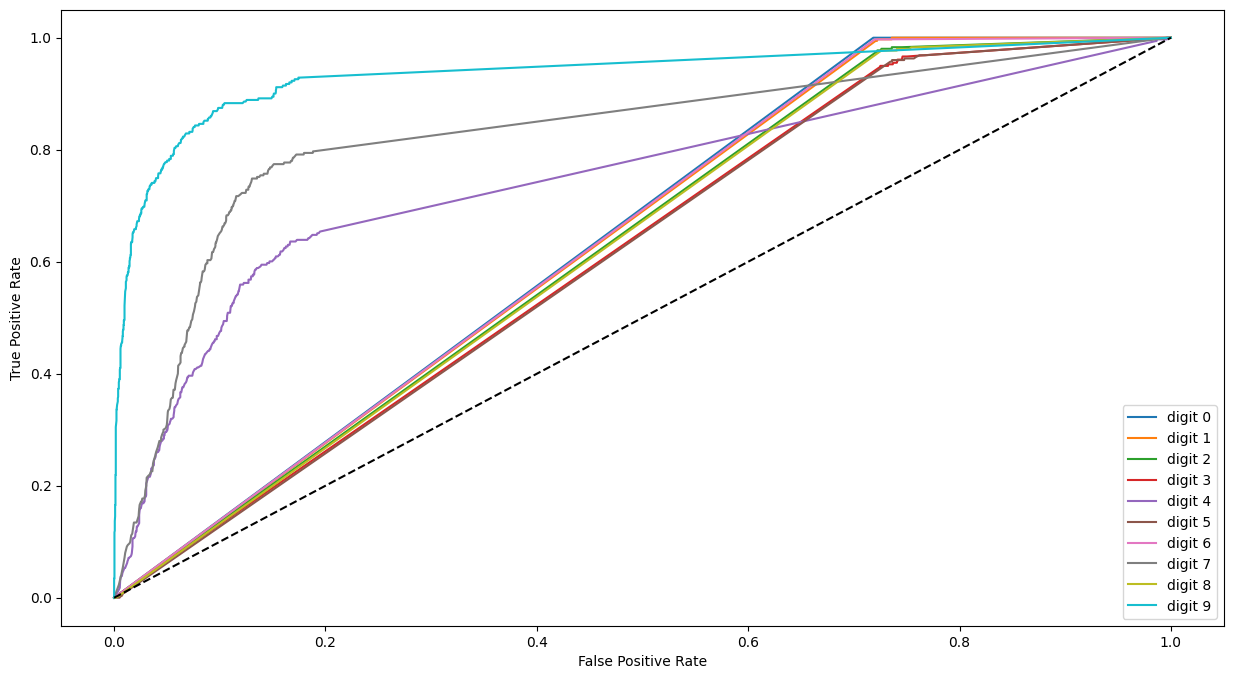

In [22]:
# pour ROC, il faudra les probabilités:
y_prob = model.predict_proba(Xtt)
roc_plot(Ytt, y_prob, np.arange(0, 1, 0.001, dtype=np.float32))


Afficher l'image testée

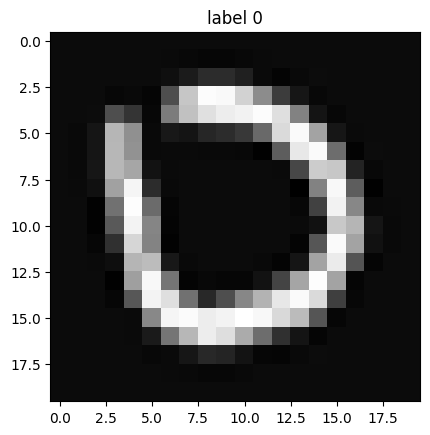

In [23]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

# Appliquer les métriques implementées pour voir le résultat